# **Physics Informed Neural Network!**

**Disclaimer**: large parts of the lab are taken from [this github repository](https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb) and [this one](https://github.com/jayroxis/PINNs) both based on the original work of [Raissi, Perdikaris and Karniadakis](https://doi.org/10.1016/j.jcp.2018.10.045).

### **Definition**

Physics Informed Neural Netwoks (PINN) relates deep learning and Partial Differential Equations (PDEs). The main idea is not to purely rely on data, but to exploit the physical model (i.e. the _residual_ of the PDE) in the loss function.

**Pro**: the approach is totally mesh-free.

**Cons**: difficult to train for complicated problems.

### **The loss**
Let us be more specific:

The loss function of a PINN is made by: 
* boundary information
* residual information 

Let us suppose that the physical system we are studying is described by a PDE of the form
$
\mathcal R({w}(\mathbf x)) = 0
$

Namely, we want to fine a surrogate Neural Network $\tilde{w}$ that minimizes:

$$
    MSE  \doteq MSE_b + MSE_p.
$$
where
$$ 
        MSE_b \doteq \frac{1}{N_b} \sum_{k=1}^{N_b} | \tilde{w}(\mathbf x_k^b) - w(\mathbf x_k^b)|^2,
$$
for $\mathbf x_k^b \in \partial \Omega$. Here, $MSE_b$ is the _boundary_ loss. While 
    $$
        MSE_{p} \doteq \frac{1}{N_p}\sum_{k=1}^{N_p}|\mathcal R(\tilde{w}(\mathbf x_k^p))|^2.
    $$

is the _physical_ (or residual) loss for $\mathbf x_k^p \in \Omega$.

### **A first Example: the 1D heat equation**

The physical model is given in the space-time domain $[0,2]\times[0,1]$: 

$$\frac{ du}{ dx} = \frac{2du}{dt}+u$$ 

with the following boundary condition $u(x,0)=6e^{-3x}$

Independent variables: x,t (input)
Dependent variables: u (outputs)
We have to find out u(x,t) for all x in range [0,2] and t in range [0,1]

Analytically, the solution is  $u(x,t) = 6e^{(-3x-2t)}$.

In [1]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

Let uf define the Neural Network!

**_Question time!_** what are the input and output dimension?

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(2,5)
        self.hidden_layer1 = nn.Linear(5,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        input = torch.cat([x,t],axis=1) # combines the column array
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        return output

In [3]:
### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def R(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2*u_t - u
    return pde

In [5]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

In [6]:
### (3) Training / Fitting
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = R(pt_x_collocation, pt_t_collocation, net) # output of R(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    
    loss.backward() 
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch,"Loss:",loss.item())

0 Loss: 2.1798009872436523
1 Loss: 2.179103136062622
2 Loss: 2.1784846782684326
3 Loss: 2.1779465675354004
4 Loss: 2.1774885654449463
5 Loss: 2.1771082878112793
6 Loss: 2.1768035888671875
7 Loss: 2.176571846008301
8 Loss: 2.1764075756073
9 Loss: 2.176301956176758
10 Loss: 2.176248550415039
11 Loss: 2.176236629486084
12 Loss: 2.176255702972412
13 Loss: 2.1762948036193848
14 Loss: 2.176344394683838
15 Loss: 2.1763949394226074
16 Loss: 2.176438808441162
17 Loss: 2.1764719486236572
18 Loss: 2.1764907836914062
19 Loss: 2.1764943599700928
20 Loss: 2.1764843463897705
21 Loss: 2.176462411880493
22 Loss: 2.1764321327209473
23 Loss: 2.176395893096924
24 Loss: 2.176356554031372
25 Loss: 2.1763193607330322
26 Loss: 2.1762847900390625
27 Loss: 2.176255702972412
28 Loss: 2.176231861114502
29 Loss: 2.1762168407440186
30 Loss: 2.1762068271636963
31 Loss: 2.176204204559326
32 Loss: 2.1762044429779053
33 Loss: 2.1762092113494873
34 Loss: 2.1762149333953857
35 Loss: 2.1762213706970215
36 Loss: 2.17622613

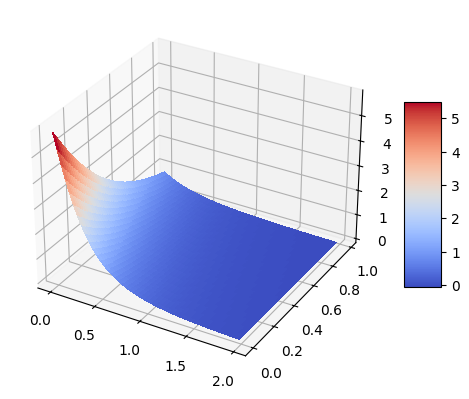

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             



fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

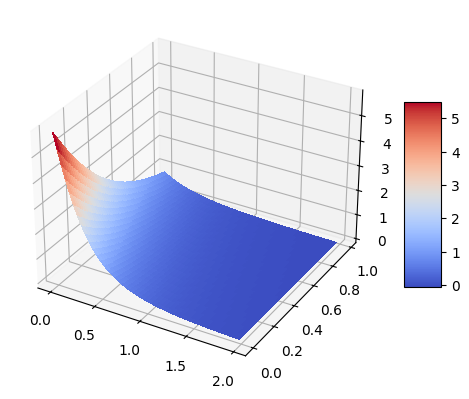

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).detach().numpy()
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).detach().numpy()
R_u = 6*np.exp(-3*pt_x - 2*pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             



fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# **Your Turn: let's change the equation**


Take a look to [this github repository](https://github.com/jayroxis/PINNs). The proposed tutorial is a bit more involved. 

We suggest to study it and to try to understand it line-by-line.

It tries to represent the solution of the Burgers equation

$$
u_t + \lambda_1 uu_x - \lambda_2 u_{xx}
$$

for some fixed parameters $\lambda_1$ and $\lambda_2$.

Since no analytical solution is present, the code uses data provided by numerical simulations.

To use them, copy the data in your google drive and use the following commands:

``import scipy.io``

``from google.colab import drive``

``drive.mount('/content/drive')``

``data = scipy.io.loadmat('MyDrive/colab/RBM_ML/data/burgers_shock.mat')``

In [11]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [12]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) ## layer, activation, layer, activation
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [13]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float()
        self.u = torch.tensor(u).float()
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
)[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        t = torch.tensor(X[:, 1:2], requires_grad=True).float()

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/")
!ls


ModuleNotFoundError: No module named 'google'

In [14]:

nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('MyDrive/colab/RBM_ML/data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

FileNotFoundError: [Errno 2] No such file or directory: 'MyDrive/colab/RBM_ML/data/burgers_shock.mat'

In [ ]:

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

In [ ]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  